# Ensemble of the best models: kmeans, ward_link_opt and clara

Try kmeans + clara; kmeans + ward_link; clara + ward_link; kmeans + clara + ward_link 

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
# from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import CLARA
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
df = pd.read_csv('../2_models/with_clean_data/solar/pca_df.csv')
pca_to_plot_df = pd.read_csv('../2_models/with_clean_data/solar/pca_to_plot_df.csv')
subset_df = pd.read_csv('../2_models/with_clean_data/solar/df_subset.csv')

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

## K-Means + clara

In [4]:
# K-Means:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

# Gaussian Mixture:
clara = CLARA(n_clusters=5, random_state=1)
clara.fit(df)
clara_labels = clara.predict(df)

KMeans is done


In [5]:
with open('results/clean_solar/clara.pickle', 'wb') as f:
    pickle.dump(clara, f)

with open('results/clean_solar/kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

Ensemble Construction by Major Voting: selecting the cluster with the highest number of votes

In [6]:
higher_weight = 2
avg_weight = 1.5
lower_weight = 1

In [7]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(clara_labels)))
voting_labels = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[kmeans_cluster] += 1*higher_weight
    votes[clara_cluster] += 1*avg_weight
    
    # Assign the data point to the cluster with the most votes
    voting_labels[i] = np.argmax(votes) 

    if i == 216:
        print(votes[kmeans_cluster])
        print(votes[clara_cluster])
        print(votes)
        print(voting_labels[i])
print('Voting based method is done')

2.0
1.5
[2.  1.5 0.  0.  0. ]
0.0
Voting based method is done


In [8]:
from scipy.spatial.distance import pdist, cdist

def dunn_index(points = np.array(df[['PC1', 'PC2', 'PC3', 'PC4']]), labels = voting_labels):
    unique_labels = np.unique(labels)
    
    max_intra_cluster_distances = []
    min_inter_cluster_distance = float('inf')

    for label in unique_labels:
        cluster_points = points[labels == label]
        if len(cluster_points) > 1:
            intra_distances = pdist(cluster_points)
            max_intra_cluster_distances.append(np.max(intra_distances))
        else:
            max_intra_cluster_distances.append(0)

    for i, label_i in enumerate(unique_labels):
        cluster_points_i = points[labels == label_i]
        for j, label_j in enumerate(unique_labels):
            if label_i < label_j:
                cluster_points_j = points[labels == label_j]
                inter_distances = cdist(cluster_points_i, cluster_points_j)
                min_inter_cluster_distance = min(min_inter_cluster_distance, np.min(inter_distances))

    if len(max_intra_cluster_distances) == 0 or min_inter_cluster_distance == float('inf'):
        return 0

    return min_inter_cluster_distance / max(max_intra_cluster_distances)

In [9]:
# def xie_beni_index(points = np.array(df[['PC1', 'PC2', 'PC3', 'PC4']]), labels = voting_labels):
#     # Compute the total scatter
#     total_scatter = np.sum(pairwise_distances(points) ** 2) / (2 * len(points))
    
#     # Compute the intra-cluster scatter
#     cluster_labels = np.unique(labels)
#     intra_cluster_scatter = 0
#     for label in cluster_labels:
#         cluster_points = points[labels == label]
#         cluster_center = np.mean(cluster_points, axis=0)
#         intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
#     intra_cluster_scatter /= len(points)
    
#     return intra_cluster_scatter / total_scatter


In [10]:
# Define a function to compute evaluation metrics
def compute_metrics(points = np.array(df[['PC1', 'PC2', 'PC3', 'PC4']]), labels = voting_labels):

    metrics = {}
    
    metrics['Silhouette Score'] = silhouette_score(points, labels)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(points, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(points, labels)
    metrics['Dunn Index'] = dunn_index(points, labels)
    # metrics['Xie-Beni Index'] = xie_beni_index(points, labels)

    return metrics


In [11]:
df['cluster_label'] = voting_labels
df['asset_id'] = subset_df['asset_id']

pca_to_plot_df['cluster_label'] = voting_labels
pca_to_plot_df['asset_id'] = subset_df['asset_id']

In [113]:
df.to_csv('results/clean_solar/gmm_kmeans.csv', index = False)

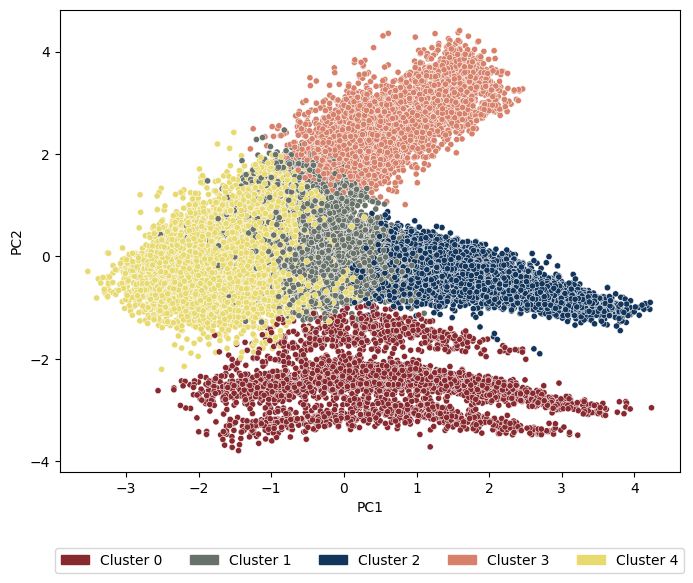

In [12]:
n_clusters = len(pca_to_plot_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_to_plot_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [13]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,PC3,PC4,asset_id,cluster_label
0,-1.163049,-2.596939,1.822468,1.204042,11,0
1,1.722822,-2.602608,0.885985,1.619102,11,0
2,1.451641,-2.588719,-0.302299,2.098042,11,0
3,0.734407,-2.237956,0.228934,2.124392,11,0
4,0.121023,-2.182634,-0.239399,2.236657,11,0


In [14]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,PC3,PC4,cluster_label
0,11,-1.163049,-2.596939,1.822468,1.204042,0
1,12,2.651199,-3.422293,1.841910,1.851594,0
2,13,1.451020,-0.049027,-1.188503,-0.373020,2
3,14,1.304045,-0.185737,-0.563057,-0.313929,1
4,15,2.222184,-0.592280,-0.773012,-0.359634,1
...,...,...,...,...,...,...
72,510,0.207552,2.331831,0.980742,0.853553,3
73,511,1.209865,3.228942,1.445532,0.986003,3
74,512,-0.236960,0.793759,-0.211348,-0.038884,3
75,513,1.510521,3.365319,1.415888,2.038786,3


In [15]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 33, 52, 58]
Cluster 1: [3, 4, 6, 9, 10, 11, 12, 15, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 48, 49, 51, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [2, 5, 7, 8, 13, 14, 16, 17, 23, 45, 46, 47, 50, 53, 54]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [55]


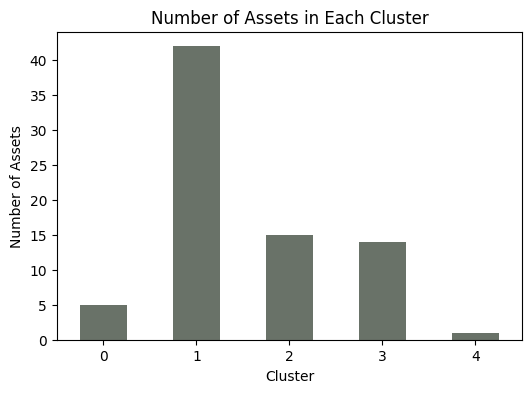

In [16]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [17]:
# Initialize an empty list to store the results
results = []

# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics()
results.append({'Model': 'clara + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [18]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index
0,clara + kmeans,0.373482,0.872458,32078.010191,0.000797


## K-Means + Ward Link

In [19]:
df = df[['PC1', 'PC2', 'PC3', 'PC4']]

In [122]:
# Ward Link:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=5)
model_ward.fit(np.array(df))
ward_labels = model_ward.labels_

In [123]:
with open('results/clean_solar/ward.pickle', 'wb') as f:
    pickle.dump(model_ward, f)

with open('results/clean_solar/ward_labels.pickle', 'wb') as f:
    pickle.dump(ward_labels, f)

In [20]:
with open('results/clean_solar/ward.pickle', 'rb') as f:
    model_ward = pickle.load(f)

with open('results/clean_solar/ward_labels.pickle', 'rb') as f:
    ward_labels = pickle.load(f)

In [21]:
len(df)

51128

In [22]:
# Voting based on cluster assignments - Major Voting
num_clusters = max(len(set(kmeans_labels)), len(set(ward_labels)))
voting_labels_ward_kmeans = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    ward_cluster = ward_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[kmeans_cluster] += 1*higher_weight
    votes[ward_cluster] += 1*avg_weight

    if i == 8273:
        print(votes)
        print(np.argmax(votes))
    
    # Assign the data point to the cluster with the most votes
    voting_labels_ward_kmeans[i] = np.argmax(votes)

print('Voting based method is done')

[0.  1.5 2.  0.  0. ]
2
Voting based method is done


In [23]:
df['cluster_label'] = voting_labels_ward_kmeans
df['asset_id'] = subset_df['asset_id']

pca_to_plot_df['cluster_label'] = voting_labels_ward_kmeans
pca_to_plot_df['asset_id'] = subset_df['asset_id']

In [24]:
df.to_csv('results/clean_solar/ward_kmeans.csv', index = False)

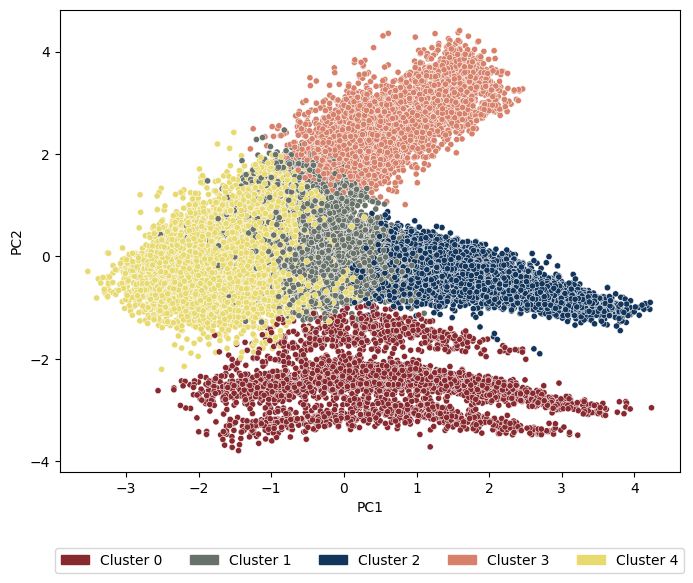

In [25]:
n_clusters = len(pca_to_plot_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_to_plot_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means and Ward Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_ward_kmeans).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [26]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,PC3,PC4,asset_id,cluster_label
0,-1.163049,-2.596939,1.822468,1.204042,11,0
1,1.722822,-2.602608,0.885985,1.619102,11,0
2,1.451641,-2.588719,-0.302299,2.098042,11,0
3,0.734407,-2.237956,0.228934,2.124392,11,0
4,0.121023,-2.182634,-0.239399,2.236657,11,0


In [27]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,PC3,PC4,cluster_label
0,11,-1.163049,-2.596939,1.822468,1.204042,0
1,12,2.651199,-3.422293,1.841910,1.851594,0
2,13,1.451020,-0.049027,-1.188503,-0.373020,2
3,14,1.304045,-0.185737,-0.563057,-0.313929,1
4,15,2.222184,-0.592280,-0.773012,-0.359634,1
...,...,...,...,...,...,...
72,510,0.207552,2.331831,0.980742,0.853553,3
73,511,1.209865,3.228942,1.445532,0.986003,3
74,512,-0.236960,0.793759,-0.211348,-0.038884,3
75,513,1.510521,3.365319,1.415888,2.038786,3


In [28]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 33, 52, 58]
Cluster 1: [3, 4, 6, 9, 10, 11, 12, 15, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 48, 49, 51, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [2, 5, 7, 8, 13, 14, 16, 17, 23, 45, 46, 47, 50, 53, 54]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [55]


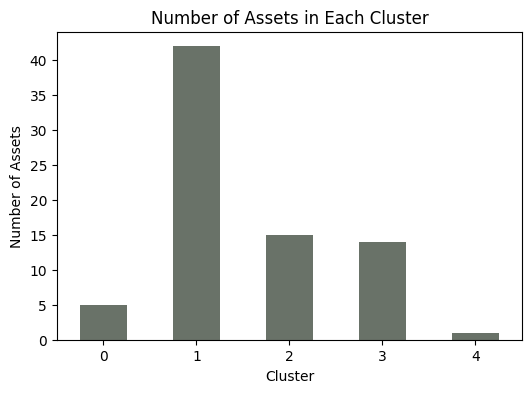

In [29]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [30]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_ward_kmeans)
results.append({'Model': 'ward link + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [31]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index
0,clara + kmeans,0.373482,0.872458,32078.010191,0.000797
1,ward link + kmeans,0.373482,0.872458,32078.010191,0.000797


## Ward Link + clara

Ensemble Construction by Cluster Fusion:

Cluster Fusion: Merge clusters from K-means and GMMs based on similarity measures between cluster centroids or density distributions

In [32]:
df = df[['PC1', 'PC2', 'PC3', 'PC4']]

In [33]:
# Voting based on cluster assignments
num_clusters = max(len(set(clara_labels)), len(set(ward_labels)))
voting_labels_ward_clara = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    clara_cluster = clara_labels[i]
    ward_cluster = ward_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[clara_cluster] += 1*avg_weight
    votes[ward_cluster] += 1*lower_weight
    
    # Assign the data point to the cluster with the most votes
    voting_labels_ward_clara[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [34]:
df['cluster_label'] = voting_labels_ward_clara
df['asset_id'] = subset_df['asset_id']

pca_to_plot_df['cluster_label'] = voting_labels_ward_clara
pca_to_plot_df['asset_id'] = subset_df['asset_id']

In [35]:
df.to_csv('results/clean_solar/gmm_ward.csv', index = False)

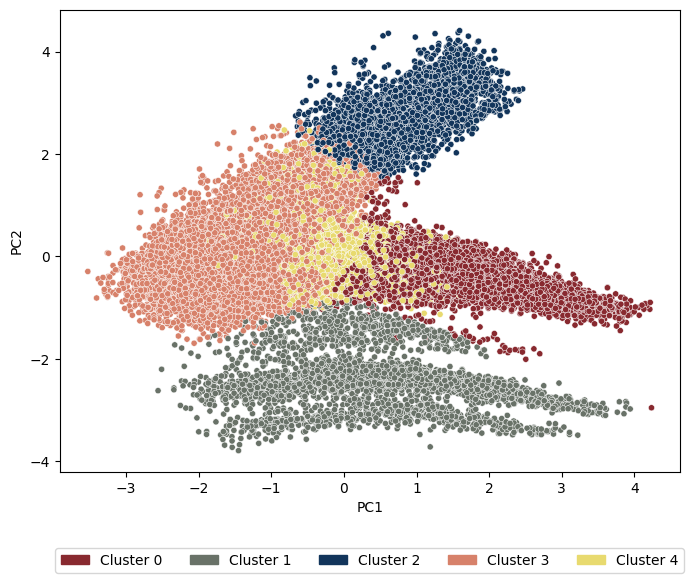

In [36]:
n_clusters = len(pca_to_plot_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_to_plot_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble Ward Link and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_ward_clara).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [37]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,PC3,PC4,asset_id,cluster_label
0,-1.163049,-2.596939,1.822468,1.204042,11,1
1,1.722822,-2.602608,0.885985,1.619102,11,1
2,1.451641,-2.588719,-0.302299,2.098042,11,1
3,0.734407,-2.237956,0.228934,2.124392,11,1
4,0.121023,-2.182634,-0.239399,2.236657,11,1


In [38]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,PC3,PC4,cluster_label
0,11,-1.163049,-2.596939,1.822468,1.204042,1
1,12,2.651199,-3.422293,1.841910,1.851594,1
2,13,1.451020,-0.049027,-1.188503,-0.373020,0
3,14,1.304045,-0.185737,-0.563057,-0.313929,0
4,15,2.222184,-0.592280,-0.773012,-0.359634,3
...,...,...,...,...,...,...
72,510,0.207552,2.331831,0.980742,0.853553,2
73,511,1.209865,3.228942,1.445532,0.986003,3
74,512,-0.236960,0.793759,-0.211348,-0.038884,2
75,513,1.510521,3.365319,1.415888,2.038786,3


In [39]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 23, 31, 32, 34, 45, 46, 47, 48, 50, 53, 54, 68]
Cluster 1: [0, 1, 33, 52, 58]
Cluster 2: [72, 74, 76]
Cluster 3: [4, 18, 20, 24, 36, 37, 38, 39, 40, 41, 42, 43, 44, 49, 55, 60, 73, 75]
Cluster 4: [11, 15, 19, 21, 22, 25, 26, 27, 28, 29, 30, 35, 51, 56, 57, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71]


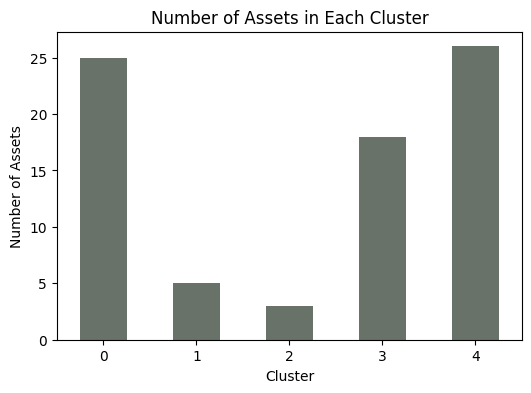

In [40]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [41]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_ward_clara)
results.append({'Model': 'clara + ward', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [42]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index
0,clara + kmeans,0.373482,0.872458,32078.010191,0.000797
1,ward link + kmeans,0.373482,0.872458,32078.010191,0.000797
2,clara + ward,0.350271,0.882911,29460.170551,0.001142


## clara + K-Means + Ward Link

In [43]:
df = df[['PC1', 'PC2', 'PC3', 'PC4']]

In [44]:
# # K-Means:
# kmeans = KMeans(n_clusters=4, random_state=1)
# kmeans_labels = kmeans.fit_predict(df)

# print('KMeans is done')

# # Ward Link:
# model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=3)
# ward_labels = model_ward.fit_predict(np.array(df))

# # Gaussian Mixture:
# gmm = GaussianMixture(n_components=5, random_state=1, verbose=1)
# gmm_labels = gmm.fit_predict(df)

Ensemble Construction by Cluster Fusion:

In [45]:
voting_labels_all = np.zeros(len(df), dtype=float)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    clara_cluster = clara_labels[i]
    ward_cluster = ward_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=float)
    votes[kmeans_cluster] += 1
    votes[clara_cluster] += 1
    votes[ward_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_all[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [46]:
df['cluster_label'] = voting_labels_all
df['asset_id'] = subset_df['asset_id']

pca_to_plot_df['cluster_label'] = voting_labels_all
pca_to_plot_df['asset_id'] = subset_df['asset_id']

In [47]:
df.to_csv('results/clean_solar/ward_kmeans_gmm.csv', index = False)

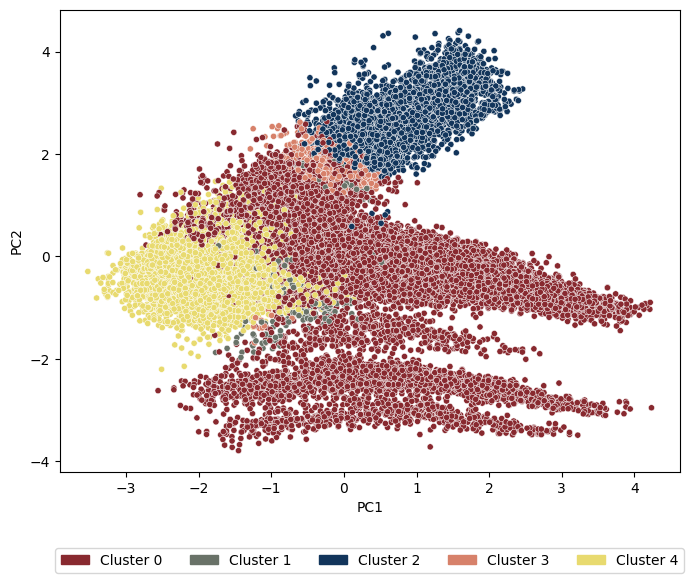

In [48]:
n_clusters = len(pca_to_plot_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_to_plot_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means, Ward Link and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_all).astype(int)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [49]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,PC3,PC4,asset_id,cluster_label
0,-1.163049,-2.596939,1.822468,1.204042,11,0
1,1.722822,-2.602608,0.885985,1.619102,11,0
2,1.451641,-2.588719,-0.302299,2.098042,11,0
3,0.734407,-2.237956,0.228934,2.124392,11,0
4,0.121023,-2.182634,-0.239399,2.236657,11,0


In [50]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,PC3,PC4,cluster_label
0,11,-1.163049,-2.596939,1.822468,1.204042,0
1,12,2.651199,-3.422293,1.841910,1.851594,0
2,13,1.451020,-0.049027,-1.188503,-0.373020,0
3,14,1.304045,-0.185737,-0.563057,-0.313929,0
4,15,2.222184,-0.592280,-0.773012,-0.359634,0
...,...,...,...,...,...,...
72,510,0.207552,2.331831,0.980742,0.853553,2
73,511,1.209865,3.228942,1.445532,0.986003,2
74,512,-0.236960,0.793759,-0.211348,-0.038884,2
75,513,1.510521,3.365319,1.415888,2.038786,2


In [51]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [36, 37, 38, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]


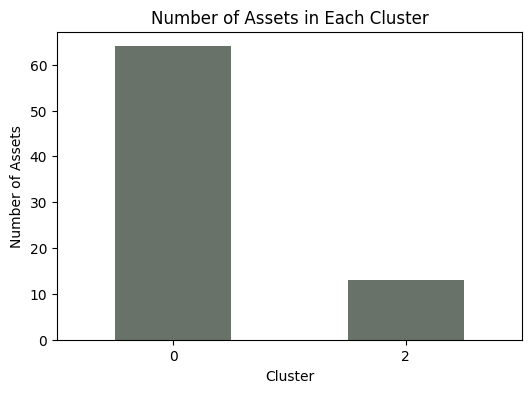

In [52]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [53]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_all)
results.append({'Model': 'ward link + kmeans + clara', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [54]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index
0,clara + kmeans,0.373482,0.872458,32078.010191,0.000797
1,ward link + kmeans,0.373482,0.872458,32078.010191,0.000797
2,clara + ward,0.350271,0.882911,29460.170551,0.001142
3,ward link + kmeans + clara,0.069315,1.810814,8365.559882,0.000934


In [56]:
normalized_df = results_df.copy()

# Define ideal and anti-ideal solutions for each metric
ideal_solution = normalized_df.copy()
anti_ideal_solution = normalized_df.copy()

# Define metrics where higher values are better
higher_is_better = ['Silhouette Score', 'Dunn Index', 'Calinski-Harabasz Index']

# Define metrics where lower values are better
lower_is_better = ['Davies-Bouldin Index']

# Set ideal and anti-ideal solutions for metrics where higher values are better
for metric in higher_is_better:
    ideal_solution[metric] = normalized_df[metric].max()
    anti_ideal_solution[metric] = normalized_df[metric].min()

# Set ideal and anti-ideal solutions for metrics where lower values are better
for metric in lower_is_better:
    ideal_solution[metric] = normalized_df[metric].min()
    anti_ideal_solution[metric] = normalized_df[metric].max()

# Calculate the distance from each alternative to the ideal and anti-ideal solutions
dist_to_ideal = ((normalized_df.iloc[:,1:] - ideal_solution) ** 2).sum(axis=1) ** 0.5
dist_to_anti_ideal = ((normalized_df.iloc[:,1:] - anti_ideal_solution) ** 2).sum(axis=1) ** 0.5

# Calculate the relative closeness to the ideal solution --> the one that has the bigger distance from the anti-ideal solution is the one thats closer to the ideal solution
normalized_df['Closeness'] = dist_to_anti_ideal / (dist_to_ideal + dist_to_anti_ideal)

# Sort the models based on their relative closeness to the ideal solution
ranked_models = normalized_df.sort_values(by='Closeness', ascending=False)

# Print the ranked models
ranked_models[['Model', 'Closeness']]

,Model,Closeness
0,clara + kmeans,1.000000e+00
1,ward link + kmeans,1.000000e+00
2,clara + ward,8.896006e-01
3,ward link + kmeans + clara,5.753812e-09


clara + kmeans

In [57]:
with open('results/clean_solar/results.pickle', 'wb') as f:
    pickle.dump(results, f)

results_df.to_csv('results/clean_solar/results.csv', index=False)